In [ ]:
# ============================================================
#  Quantum Information Processing II — Driven Two-Level System
# ------------------------------------------------------------
#  Author: Gabriele Johannes Giuli
#  Email: ggiuli@ethz.ch
#  Institution: ETH Zürich
#  Description: Simulation of a driven two-level quantum system
#               subject to spontaneous decay using QuTiP.
#  Created: 2025-10-19
# ============================================================

import qutip as qt
import numpy as np
import matplotlib.pyplot as plt

# Two-Level system
As we will be working with ions (who would have thought!) we would like to better understand their dynamics. We often consider two internal states the *excited* and *ground* states. Thus we represent ions' degrees of freedoms as two-level systems or *qubits*. The Hamiltonian therefore is
$$
\hat{H}_\text{bare} = \frac{\hbar}{2}\omega_{eg}\hat{\sigma}_z,
$$
where $\hat{\sigma}_z = |e\rangle\langle e| - |g\rangle\langle g|$ and $\omega_{eg}$ is the energy splitting between the excited state $|e\rangle$ and the ground state $|g\rangle$. We will use the pyhton *qutip* package to play round with this system.


Note that, from this point onwwards, we will set $\hbar = 1$ in all the simuations.

In [2]:
omega_eg = 10

H_bare = 0.5*omega_eg*qt.sigmaz()
H_bare

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 5.  0.]
 [ 0. -5.]]

We can conpute the discrete energy levels by computiong the eigenvalues of the Hamiltonian. Although the eigenenergies are trivial in this case, we can use qutip to compute them. In the end, we would expect an energy splitting of
$$
E = \hbar\omega_{eg}.
$$
Remember that the energy of the ground state is "arbitrarily" chosen, what we really care about is the splitting.

In [3]:
energies = H_bare.eigenenergies()
print("Energy levels:", energies)

Energy levels: [-5.  5.]


The system, as it is now, it is not that interesting. We can add a coherent drive (e.g. a laser field) that will make the dynamics of the systme more interesnting
## Driven Two-Level System

If we were to start from the celebrated *dipole interaction hamiltonian*, expand it and perform *rotating-wave approximaton* (have a look at the *Quantum Optics* notes), we would arrive to the following interaction Hamiltonian:
$$
\hat{H}_\text{int} = \frac{\hbar\Omega}{2}(e^{-i\omega_L t} \hat{\sigma}_+ + e^{+i\omega_L t} \hat{\sigma}_-),
$$
where $\hat{\sigma}_+ = |e\rangle\langle g|$, $\hat{\sigma}_- = |g\rangle\langle e|$, $\omega_L$ is the laser frequency and $\Omega$ is the Rabi frequency. Therefore, the total Hamiltonian in rotating frame becomes
$$
\hat{H}_\text{tot}^I = \frac{\hbar\Omega}{2}(e^{-i\Delta t} \hat{\sigma}_+ + e^{+i\Delta t} \hat{\sigma}_-),
$$
where we define the detuning as $\Delta = \omega_L - \omega_{eg}$. For now, let's assume that the detuning is zero. We get

In [4]:
Omega = 1*(2*np.pi)

H_int = 0.5*Omega*(qt.sigmap() + qt.sigmam())
H_int

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0.         3.14159265]
 [3.14159265 0.        ]]

### Rabi Oscillations
It is no secret that the resonant system will drive Rabi oscillations in the population. If we start with the excited state
$$
|\Psi_0\rangle = |e\rangle
$$
we get the following time evolution:

In [5]:
psi_0 = qt.basis(2, 0)
psi_0

Quantum object: dims=[[2], [1]], shape=(2, 1), type='ket', dtype=Dense
Qobj data =
[[1.]
 [0.]]

<>:7: SyntaxWarning: invalid escape sequence '\l'
<>:8: SyntaxWarning: invalid escape sequence '\l'
<>:7: SyntaxWarning: invalid escape sequence '\l'
<>:8: SyntaxWarning: invalid escape sequence '\l'
/var/folders/b6/6j8727kd7j70w1zj_dxmknww0000gn/T/ipykernel_59755/3558191541.py:7: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel('$\langle\sigma_z\\rangle$')
/var/folders/b6/6j8727kd7j70w1zj_dxmknww0000gn/T/ipykernel_59755/3558191541.py:8: SyntaxWarning: invalid escape sequence '\l'
  plt.title('Time Evolution of $\langle\sigma_z\\rangle$')
/Users/gabrielegiuli/Desktop/tip/.venv/lib/python3.12/site-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


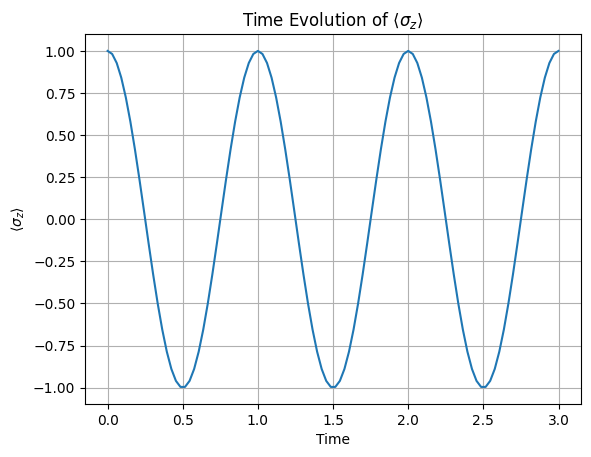

In [6]:
simulation_times = np.linspace(0, 3, 100)
solutions = qt.sesolve(H_int, psi_0, simulation_times, [qt.sigmaz()])

# Plot the results
plt.plot(simulation_times, solutions.expect[0])
plt.xlabel('Time')
plt.ylabel('$\langle\sigma_z\\rangle$')
plt.title('Time Evolution of $\langle\sigma_z\\rangle$')
plt.grid(True)
plt.show()

## Introducing Dissipation
This is a good starting point! However, in the real world we will have to take into account non-idealities. In particular we will consider two sources of decoherence:
1. spontaneous emission and
2. pure decoherence

To model this phenomena we will use the *Density Matrix* and *Lindblad Master Equation* formalism. For a system subject to coherent drive $\hat{H}$, and a set of dissipative dynamics (more on that later) $\{(\hat{L}_i): i = 1,2,\dots, N\}$ is given by the master equation
$$
\frac{\mathrm{d}}{\mathrm{d}t}\hat{\rho} = - \frac{i}{\hbar}\left[\hat{H}, \hat{\rho}\right] + \frac{1}{2}\sum_{i = 1}^N \left(2 \hat{L}_i\hat{\rho}\hat{L}_i^\dagger - \left\{\hat{L}_i^\dagger\hat{L}_i, \hat{\rho}\right\}\right),
$$
where $\{\cdot, \cdot\}$ is the anticommutator. But let's delve a bit more into the the so called *Jump Operator* structure. In particular $\hat{L}$ denotes the non-hermitian (or dissipative) action that the system is subject to, and is usually expressed as
$$
\hat{L}_i = \sqrt{\gamma_i}\,\hat{O}_i.
$$
Therefore, $\hat{O}$ represents the action of the jump operator, while $\gamma_i$ gives its strenght.

### Spontaneous Emission
As you will know, the coupling of the atom to the continuum of electromagentic field modes will cause *spontaneous emission* to occurr. The jump operator therefore becomes
$$
\hat{L}_\text{se} = \sqrt{\Gamma} \,\sigma_-.
$$
We can implement it in qutip as follows. As an initial example, let's consider the bare system being initialised in its excited state. We will expect an exponential decay of the excited population from the spontaneous decay:


In [7]:
rho_0 = psi_0 * psi_0.dag()
rho_0

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[1. 0.]
 [0. 0.]]

In [8]:
decay_rate = 3
L_se = np.sqrt(decay_rate)*qt.sigmam()
L_se

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=False
Qobj data =
[[0.         0.        ]
 [1.73205081 0.        ]]

In [9]:
solutions_se = qt.mesolve(H_bare, rho_0, simulation_times, [L_se], [qt.sigmaz()])

# Plot the results
plt.plot(simulation_times, solutions_se.expect[0], 'green')
plt.xlabel('Time')
plt.ylabel('$\langle\sigma_z\\rangle$')
plt.title('Time Evolution of $\langle\sigma_z\\rangle$')
plt.grid(True)
plt.show()

<>:6: SyntaxWarning: invalid escape sequence '\l'
<>:7: SyntaxWarning: invalid escape sequence '\l'
<>:6: SyntaxWarning: invalid escape sequence '\l'
<>:7: SyntaxWarning: invalid escape sequence '\l'
/var/folders/b6/6j8727kd7j70w1zj_dxmknww0000gn/T/ipykernel_59755/1892575600.py:6: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel('$\langle\sigma_z\\rangle$')
/var/folders/b6/6j8727kd7j70w1zj_dxmknww0000gn/T/ipykernel_59755/1892575600.py:7: SyntaxWarning: invalid escape sequence '\l'
  plt.title('Time Evolution of $\langle\sigma_z\\rangle$')


Great, this is ax expected: as time passes by a photon is more lilely to be emitted and the atom decays to the ground state. Let's go back to the driven state and see what happnes:


<>:6: SyntaxWarning: invalid escape sequence '\l'
<>:7: SyntaxWarning: invalid escape sequence '\l'
<>:6: SyntaxWarning: invalid escape sequence '\l'
<>:7: SyntaxWarning: invalid escape sequence '\l'
/var/folders/b6/6j8727kd7j70w1zj_dxmknww0000gn/T/ipykernel_59755/2325271392.py:6: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel('$\langle\sigma_z\\rangle$')
/var/folders/b6/6j8727kd7j70w1zj_dxmknww0000gn/T/ipykernel_59755/2325271392.py:7: SyntaxWarning: invalid escape sequence '\l'
  plt.title('Time Evolution of $\langle\sigma_z\\rangle$')


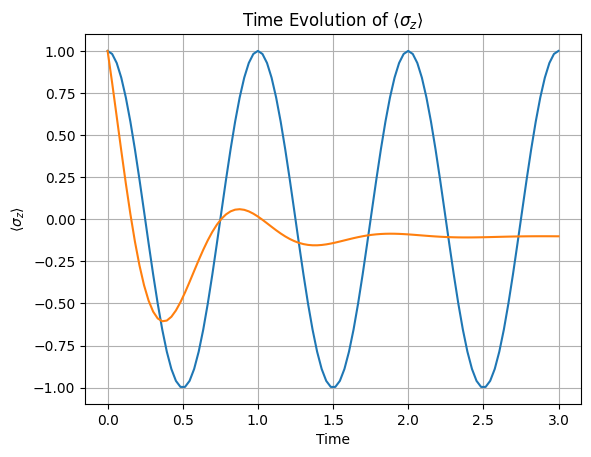

In [10]:

solutions_se_int = qt.mesolve(H_int, rho_0, simulation_times, [L_se], [qt.sigmaz()], options={'store_states': True})
# Plot the results
plt.plot(simulation_times, solutions.expect[0])
plt.plot(simulation_times, solutions_se_int.expect[0])
plt.xlabel('Time')
plt.ylabel('$\langle\sigma_z\\rangle$')
plt.title('Time Evolution of $\langle\sigma_z\\rangle$')
plt.grid(True)
plt.show()

We see that as time passes, the rabi oscillations are damped. This is because the spontaneous emission causes decoherence to decay. Once the state is in a mixed state, all contrast is gone as the coherence is lost. We can in fact plot the purity of the state as a function of time.

<>:11: SyntaxWarning: invalid escape sequence '\l'
<>:11: SyntaxWarning: invalid escape sequence '\l'
/var/folders/b6/6j8727kd7j70w1zj_dxmknww0000gn/T/ipykernel_59755/603747064.py:11: SyntaxWarning: invalid escape sequence '\l'
  ax2.set_ylabel('$\langle\sigma_z\\rangle$', color='green')


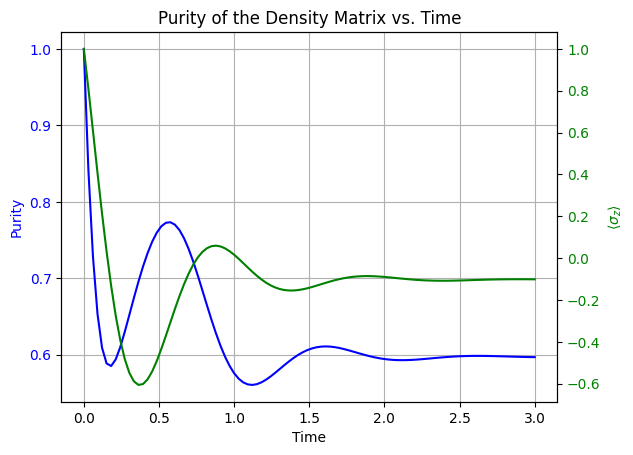

In [11]:
purity_values = [rho.purity() for rho in solutions_se_int.states]

fig, ax1 = plt.subplots()
ax1.plot(simulation_times, purity_values, color='blue')
ax1.set_xlabel('Time')
ax1.set_ylabel('Purity', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(simulation_times, solutions_se_int.expect[0], color='green')
ax2.set_ylabel('$\langle\sigma_z\\rangle$', color='green')
ax2.tick_params(axis='y', labelcolor='green')

plt.title('Purity of the Density Matrix vs. Time')
ax1.grid(True)

plt.show()

What is interesting is that the spontaneous emission is in the end driving us towards a pure state, or the ground state!

### Pure Decoherence
We consider another source of decoherence. In this case we do not modify the energy of the state (as we saw in spontaneous decay, as we emitted a photon). In the lab, pure decoherence might come from a laser's intensity noise, that will make the Rabi frequency fluctuate. The corresponding jump operator is
$$
\hat{L}_\text{d} = \sqrt{\gamma_\mathrm{d}}\,\hat{\sigma}_z.
$$

In [12]:
depahsing_rate = 3
L_d = np.sqrt(depahsing_rate)*qt.sigmaz()
L_d

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 1.73205081  0.        ]
 [ 0.         -1.73205081]]

<>:6: SyntaxWarning: invalid escape sequence '\l'
<>:7: SyntaxWarning: invalid escape sequence '\l'
<>:6: SyntaxWarning: invalid escape sequence '\l'
<>:7: SyntaxWarning: invalid escape sequence '\l'
/var/folders/b6/6j8727kd7j70w1zj_dxmknww0000gn/T/ipykernel_59755/409684604.py:6: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel('$\langle\sigma_z\\rangle$')
/var/folders/b6/6j8727kd7j70w1zj_dxmknww0000gn/T/ipykernel_59755/409684604.py:7: SyntaxWarning: invalid escape sequence '\l'
  plt.title('Time Evolution of $\langle\sigma_z\\rangle$')


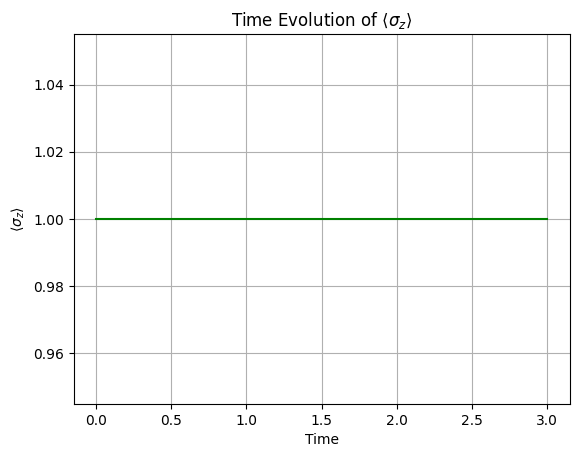

In [13]:
solutions_se_d = qt.mesolve(H_bare, rho_0, simulation_times, [L_d], [qt.sigmaz()])

# Plot the results
plt.plot(simulation_times, solutions_se_d.expect[0], 'green')
plt.xlabel('Time')
plt.ylabel('$\langle\sigma_z\\rangle$')
plt.title('Time Evolution of $\langle\sigma_z\\rangle$')
plt.grid(True)
plt.show()

As expected, in this case we do not decay from the excited state to the ground state. Let's now have a look at the driven system

In [14]:
solutions_d_int = qt.mesolve(H_int, rho_0, simulation_times, [L_d], [qt.sigmaz()], options={'store_states': True})
purity_values = [rho.purity() for rho in solutions_d_int.states]

fig, ax1 = plt.subplots()
ax1.plot(simulation_times, purity_values, color='blue')
ax1.set_xlabel('Time')
ax1.set_ylabel('Purity', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(simulation_times, solutions_d_int.expect[0], color='green')
ax2.set_ylabel('$\langle\sigma_z\\rangle$', color='green')
ax2.tick_params(axis='y', labelcolor='green')

plt.title('Purity of the Density Matrix vs. Time')
ax1.grid(True)

plt.show()

<>:12: SyntaxWarning: invalid escape sequence '\l'
<>:12: SyntaxWarning: invalid escape sequence '\l'
/var/folders/b6/6j8727kd7j70w1zj_dxmknww0000gn/T/ipykernel_59755/2898600417.py:12: SyntaxWarning: invalid escape sequence '\l'
  ax2.set_ylabel('$\langle\sigma_z\\rangle$', color='green')
